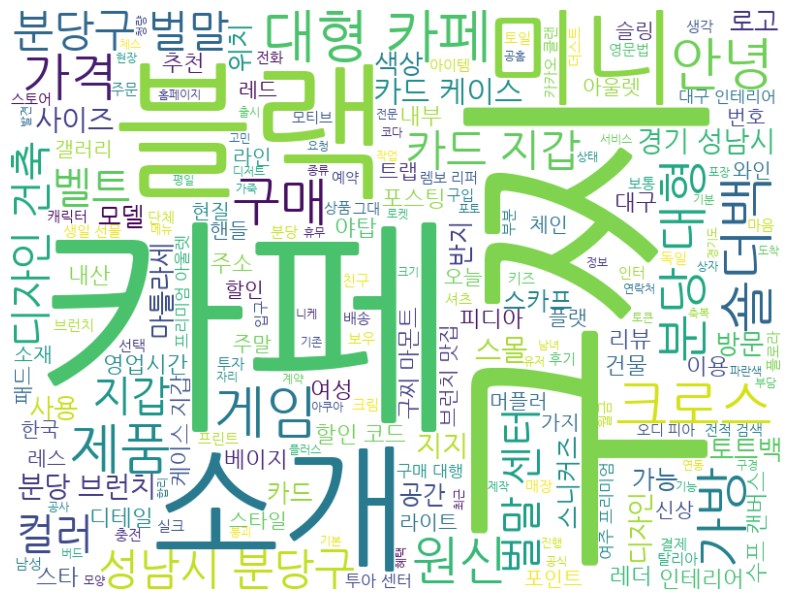

데이터가 gg_blog_description.csv 파일로 저장되었습니다.


In [5]:
import requests
import re
import csv
import emoji
from konlpy.tag import Mecab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()

client_id = os.getenv('CLIENT_ID') 
client_secret = os.getenv('CLIENT_SECRET') 
stopwords_file =os.getenv('STOPWORDS_FILE') 
font_path = os.getenv('FONT_PATH') 
csv_filename=os.getenv('OUTPUT_CSV_FILENAME_TEMPLATE') 

# 불용어 로드 함수
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        stopwords = file.read().splitlines()
    return stopwords

# 블로그 데이터 수집 함수
def get_blog_data(query, display, start=1):
    url = "https://openapi.naver.com/v1/search/blog"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret
    }
    params = {
        "query": query,
        "display": display,
        "start": start
    }
    response = requests.get(url, headers=headers, params=params)
    
    # 응답 상태 코드 확인
    if response.status_code == 200:
        data = response.json()
        if 'items' in data:
            return data['items']
        else:
            print("Error: 'items' key not found in response.")
            return []
    else:
        print(f"Error: API request failed with status code {response.status_code}")
        return []

# 텍스트 전처리 함수
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # HTML 태그 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글 및 공백을 제외한 문자 제거
    text = re.sub(r'\s+', ' ', text)  # 연속된 공백을 하나의 공백으로 변경
    text = emoji.replace_emoji(text, replace='')  # 이모티콘 제거
    return text

# Mecab 초기화
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

# 본문 내용 추출 및 전처리 함수
def extract_content(items, stopwords):
    contents = []
    for item in items:
        content = clean_text(item['description'])
        tokens = mecab.nouns(content)
        filtered_tokens = [word for word in tokens if word not in stopwords and len(word) > 1]
        contents.append({'nouns': ' '.join(filtered_tokens), 'link': item['link']})
    return contents

# 워드클라우드 생성 및 출력 함수
def create_wordcloud(text):
    wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=600).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 데이터 저장 함수
def save_to_csv(contents, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['nouns', 'link'])
        for content in contents:
            writer.writerow([content['nouns'], content['link']])

# 메인 함수
def main():
    query = input("검색할 단어를 입력하세요: ")
    total_results = int(input("검색할 블로그 글 수를 입력하세요: "))
    display = 100  # 한 번에 최대 100개 결과 가져오기
    
    # 불용어 로드
    stopwords = load_stopwords(stopwords_file)
    
    # 네이버 블로그 데이터 수집
    all_contents = []
    for start in range(1, total_results + 1, display):
        items = get_blog_data(query, display, start=start)
        contents = extract_content(items, stopwords)
        all_contents.extend(contents)
    
    # 모든 텍스트 합치기
    text = ' '.join([content['nouns'] for content in all_contents])
    
    # 워드클라우드 생성 및 출력
    create_wordcloud(text)
    
    # 데이터 저장
    filename = csv_filename.format(query)
    save_to_csv(all_contents, filename)
    print(f"데이터가 {filename} 파일로 저장되었습니다.")

# 프로그램 실행
if __name__ == "__main__":
    main()
